# ***RNN - Recurrent Neural Networks***

```pip install yfinance``` komutunu kullanarak, kendinizin karar vereceği 2 farkli hisse senedi seçin ve bu hisse senetlerinin gelecek fiyatlarını LSTM kullanarak tahmin (1-step forecast) edin.

RNN'de karşılaşılan sorunları ve neden LSTM'e ihtiyaç duyulduğunu kısaca tartışın.

LSTM'de yer alan epoch ve batch size parametrelerinin ne olduğunu araştırın. Soruyu farklı ```epoch``` ve ```batch_size``` değerleri ile tekrar çözün ve sonucu degerlendirin.

---
## ***Keras ile LSTM (Long Short Term Memory) modeli olusturma***


In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# model kutuphaneleri
from keras import Sequential
from keras.layers import Dense, LSTM

# standartlastirma icin
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
from datetime import datetime, timedelta, timezone

# uyarilari gosterme
import warnings
warnings.filterwarnings('ignore')

- Amazon'un 2016 başından olan günlük hisse senedi bilgilerini kullanarak tahmin yapmaya çalışacağız.

In [73]:
#hisseler = ['AMZN', 'TSLA']
# amazon verilerini indirelim
hisseler = ['AMZN']
hisse_fiyatlari = yf.download(hisseler,start = '2016-01-01',end = '2020-06-01',
                              interval='1d', prepost=True)

[*********************100%***********************]  1 of 1 completed


In [74]:
hisse_fiyatlari

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-12-31,686.080017,687.750000,675.890015,675.890015,675.890015,3749600
2016-01-04,656.289978,657.719971,627.510010,636.989990,636.989990,9314500
2016-01-05,646.859985,646.909973,627.650024,633.789978,633.789978,5822600
2016-01-06,622.000000,639.789978,620.309998,632.650024,632.650024,5329200
2016-01-07,621.799988,630.000000,605.210022,607.940002,607.940002,7074900
...,...,...,...,...,...,...
2020-05-22,2455.010010,2469.850098,2430.129883,2436.879883,2436.879883,2867100
2020-05-26,2458.000000,2462.000000,2414.060059,2421.860107,2421.860107,3568200
2020-05-27,2404.989990,2413.580078,2330.000000,2410.389893,2410.389893,5056900


In [75]:
# en yuksek ve en dusuk fiyatlardan ortalama hesaplanir
hisse_fiyatlari["Average"] = (hisse_fiyatlari["High"] + hisse_fiyatlari["Low"])/2
hisse_fiyatlari.head()

,Open,High,Low,Close,Adj Close,Volume,Average
Date,,,,,,,
2015-12-31,686.080017,687.750000,675.890015,675.890015,675.890015,3749600,681.820007
2016-01-04,656.289978,657.719971,627.510010,636.989990,636.989990,9314500,642.614990
2016-01-05,646.859985,646.909973,627.650024,633.789978,633.789978,5822600,637.279999
2016-01-06,622.000000,639.789978,620.309998,632.650024,632.650024,5329200,630.049988
2016-01-07,621.799988,630.000000,605.210022,607.940002,607.940002,7074900,617.605011


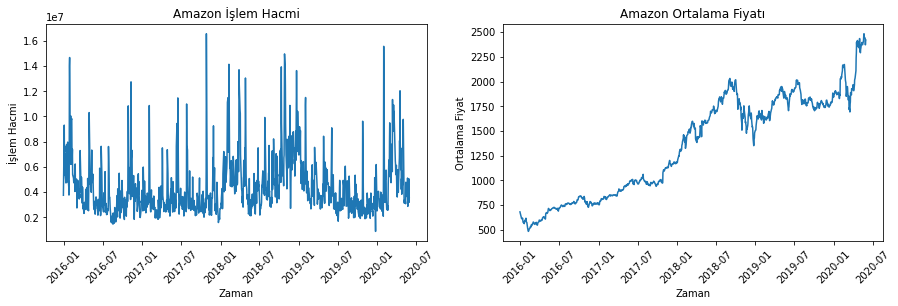

In [76]:
plt.figure(figsize=(15, 4))
plt.subplot(121)
sns.lineplot(x = hisse_fiyatlari.index, y = hisse_fiyatlari.Volume)
plt.title("Amazon İşlem Hacmi")
plt.xlabel("Zaman")
plt.ylabel("İşlem Hacmi")
plt.xticks(rotation = 45)

plt.subplot(122)
sns.lineplot(x = hisse_fiyatlari.index, y = hisse_fiyatlari.Average)
plt.title("Amazon Ortalama Fiyatı")
plt.xlabel("Zaman")
plt.ylabel("Ortalama Fiyat")
plt.xticks(rotation = 45)

plt.show()

- Tahmin için işlem hacmi ve ortalama sütunlarını bir diziye atalım ve 0 ile 1 arasında olacak şekilde standardize edelim.

In [77]:
# işlem hacmi ve ortalama sütunlarını bir diziye atalım
girdi_verileri = hisse_fiyatlari.iloc[:,[5,6]].values

# 0 ile 1 arasında olacak şekilde standardize edelim
sc= MinMaxScaler(feature_range=(0,1))
girdi_verileri[:,0:2] = sc.fit_transform(girdi_verileri[:,:])

- Hisse senedi fiyatlarını tahmin ederken son 50 işlem günündeki fiyatları ve işlem hacmini kullanacağız. Verimizin %30'unu da test kümesi olarak kullanacağız. Hedef değişkenimiz de bugün ki fiyat olacak ve bu şekilde devam edecek.

In [78]:
# son 50 işlem günündeki fiyatları ve işlem hacmini kullanacağız
lookback= 50

# verimizin %30'unu da test kümesi olarak kullanacağız
test_size=int(.3 * len(hisse_fiyatlari))
X=[]
y=[]
for i in range(len(hisse_fiyatlari)-lookback-1):
    t=[]
    # i inci gun icin i den sonraki 50 gunun islem hacmi ve ortalama fiyat degerlerini al
    for j in range(0,lookback):        
        t.append(girdi_verileri[[(i+j)], :])
    X.append(t)
    # i inci gunden 50 gun sonrasinin ortalama fiyatini ekle 
    y.append(girdi_verileri[i+ lookback,1])

- Verileri kontrol edelim. X verilerinin son değeri, bir gün öncekinin hedef değeri olmalı.

In [79]:
# 2 inci gunun son degerlerinden ortalama fiyat  1 inci gunun hedef fiyatiyla ayni olmali
print(X[1][-1])
print(y[0])
print("-----------")
print(X[100][-1])
print(y[99])

[[0.19099447 0.0449606 ]]
0.044960599940753215
-----------
[[0.14645141 0.1366846 ]]
0.13668459930230212


- Verilerimiz başarılı bir şekilde hazırladık. LSTM girdi verisi olarak 3 boyutlu bir veriye ihtiyaç duymaktadır.Bunlar;
    - veri sayısı (gun sayisi), 
    - test adımı sayısı (loopback sayisi), 
    - girdi olarak kullanılacak özellik sayısıdır (islem hacmi ve ortalama fiyat). 

- reshape ile yeniden boyutlandirabilir ve verileri uyumlu hale getiririz.

In [82]:
# listeleri numpy array e donustur
X, y= np.array(X), np.array(y)
# test verisini ayir
X_test = X[:test_size+lookback]
# LSTM girdi verisi olarak 3 boyutlu bir veriye ihtiyaç duymaktadır 
# Bunlar veri sayısı, test adımı sayısı, girdi olarak kullanılacak özellik sayısıdır.
X = X.reshape(X.shape[0],lookback, 2)
X_test = X_test.reshape(X_test.shape[0],lookback, 2)
print(X.shape)
print(X_test.shape)

(1059, 50, 2)
(383, 50, 2)


### ***Model Mimarisini Belirleme***

In [83]:
model = Sequential()
# ilk LSTM katmani girdi boyutu loopback ve ozellik sayisidir
model.add(LSTM(units=30, return_sequences=True, input_shape=(X.shape[1],2)))
model.add(LSTM(units=30, return_sequences=True))
model.add(LSTM(units=30))
model.add(Dense(units=1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 50, 30)            3960      
_________________________________________________________________
lstm_5 (LSTM)                (None, 50, 30)            7320      
_________________________________________________________________
lstm_6 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 18,631
Trainable params: 18,631
Non-trainable params: 0
_________________________________________________________________


### ***Modeli Derleme ve Fit Etme***

In [84]:
model.compile(optimizer='adam', loss='mean_squared_error')

# batch_size her bir iterasyonda ne kadar veri kullanilacagini belirler, default degeri 32 dir, 
# epoch iterasyon sayisini belirler
model.fit(X, y, epochs=200, batch_size=32, verbose=0)

### ***Modelden Tahmin Uretme***

In [85]:
tahmin_değerleri= model.predict(X_test)

### ***Tahmin Grafigi***

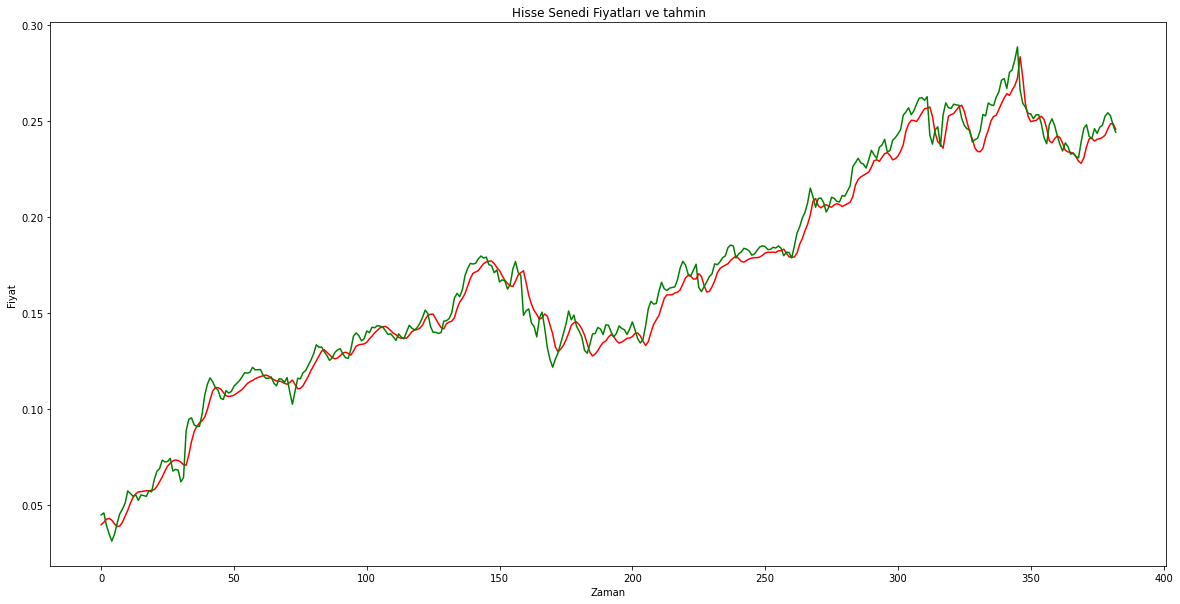

In [86]:
plt.figure(figsize=(20,10))
plt.plot(tahmin_değerleri, color= 'red')
plt.plot(girdi_verileri[lookback:test_size+(2*lookback),1], color='green')
plt.title("Hisse Senedi Fiyatları ve tahmin")
plt.xlabel("Zaman")
plt.ylabel("Fiyat")
plt.show()

---
### ***Modeli Farkli Parametrelerle Fit Etme***

#### ***batch_size=100***

In [87]:
# batch_size her bir iterasyonda ne kadar veri kullanilacagini belirler, default degeri 32 dir, 
# epoch iterasyon sayisini belirler
model.fit(X, y, epochs=200, batch_size=100, verbose=0)

### ***Modelden Tahmin Uretme***

In [88]:
tahmin_değerleri= model.predict(X_test)

### ***Tahmin Grafigi***

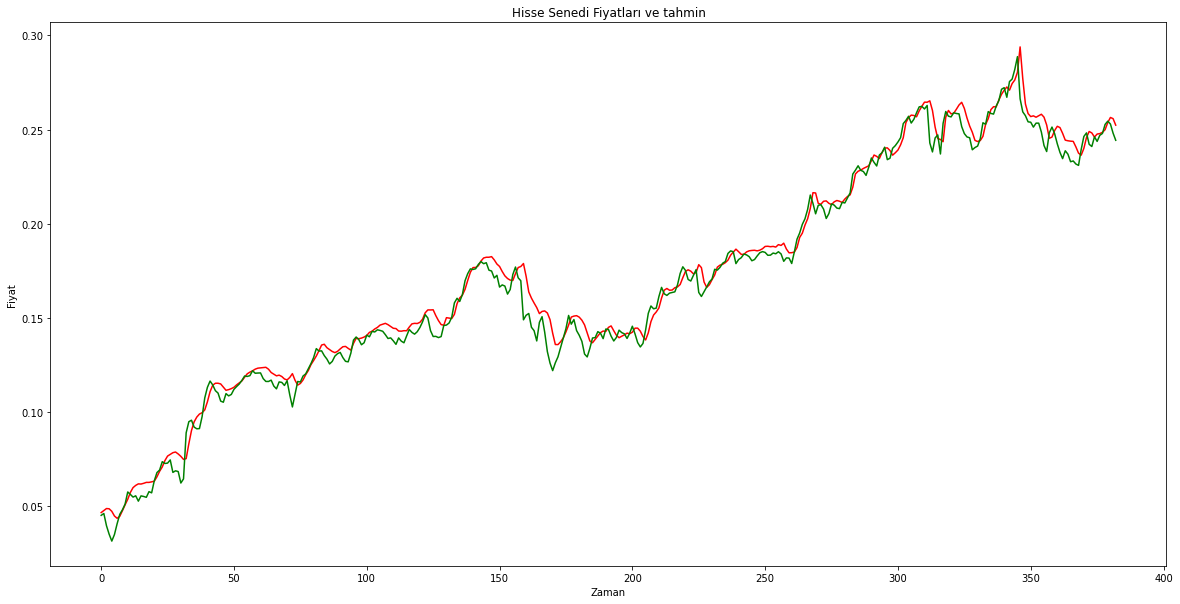

In [89]:
plt.figure(figsize=(20,10))
plt.plot(tahmin_değerleri, color= 'red')
plt.plot(girdi_verileri[lookback:test_size+(2*lookback),1], color='green')
plt.title("Hisse Senedi Fiyatları ve tahmin")
plt.xlabel("Zaman")
plt.ylabel("Fiyat")
plt.show()

- batch size parametresini arttirdigimizda tahmin degerleri grafigi gercek deger grafiginin ustunde cikmaktadir.

---
### ***Modeli Farkli Parametrelerle Fit Etme***

#### ***epoch=50***

In [92]:
# batch_size her bir iterasyonda ne kadar veri kullanilacagini belirler, default degeri 32 dir, 
# epoch iterasyon sayisini belirler
model.fit(X, y, epochs=50, batch_size=32, verbose=0)

### ***Modelden Tahmin Uretme***

In [93]:
tahmin_değerleri= model.predict(X_test)

### ***Tahmin Grafigi***

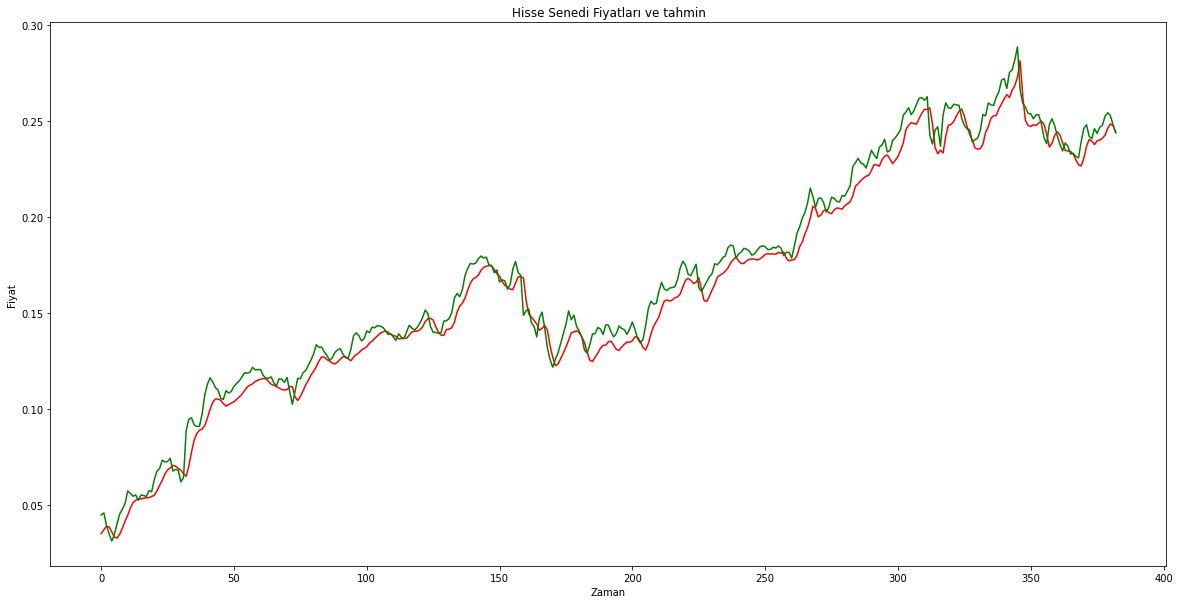

In [94]:
plt.figure(figsize=(20,10))
plt.plot(tahmin_değerleri, color= 'red')
plt.plot(girdi_verileri[lookback:test_size+(2*lookback),1], color='green')
plt.title("Hisse Senedi Fiyatları ve tahmin")
plt.xlabel("Zaman")
plt.ylabel("Fiyat")
plt.show()

- epoch degerini azalttigimizda tahminler ile gercek deger grafigi arasindaki farklarin arttigi gozlenmistir.